# Movie Lens Recsys

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7a0469edf071c7f7a466009ceaccceed50b151f0aa033e6e4ade33ccf0897c51
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Data Preprocessing and Baseline Algorithms

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items))
    
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1,itemID-1] = rating

    ###########         end         ###########
    return matrix

In [9]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
                # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]

            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]

            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
                
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))

        # Define function for converting 1-5 rating to 0/1 (like / don't like)

        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [12]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [14]:
np.all(x<=1)

True

In [15]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1174.25it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [18]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [19]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [20]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:24, 1182.93it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Similarity in Collaborative Filtering

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        
        similarity_matrix = 1/(pairwise_distances(matrix, metric='euclidean') + 1)
        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1 - pairwise_distances(matrix, metric='jaccard')


        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
            
            columns = np.sum(predictionMatrix, axis=0)
            
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
            
            columns = np.sum(predictionMatrix, axis=0)
            
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix.T
            
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [22]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [24]:
SimBasedRecSys.somethingelse(I)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

### (b)

The Jaccard similarity gives us a measure of similarity through measuring the number of items they have in common and dividing by the their union. It basically looks for users that are similar through finding the commonly rated items or looks for items that are similar through finding the common users that have rated the items. It's likely that users that have rated high on a certain movie will also rate high on a movie that is very similar. Jaccard is great in capturing this. 

## Collaborative Filtering Predictions

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [27]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [28]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:30, 1105.51it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [32]:
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [33]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:27, 1137.19it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')

In [38]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2118.24it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2127.18it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2122.73it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2114.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2100.80it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2118.05it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2134.74it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2148.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2127.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2111.38it/s]


Processing algorithm user-cosine


20000it [00:09, 2093.70it/s]
20000it [00:09, 2107.59it/s]
20000it [00:09, 2067.75it/s]
20000it [00:09, 2114.72it/s]
20000it [00:09, 2123.67it/s]


Processing algorithm item-cosine


20000it [00:09, 2117.58it/s]
20000it [00:09, 2134.85it/s]
20000it [00:09, 2106.82it/s]
20000it [00:09, 2122.46it/s]
20000it [00:09, 2090.58it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

The user-user collaborative filtering have slightly lower rsme and also have smaller confidence interval. Therefore,user-user tends to yield the best result among all algorithms. 

In addition, the average number of ratings per users will be relatively higher compared to average number of ratings per item, because there are more items than the users. This allows for better similarity and the higher the number of ratings, less bias the model is. 

Lastly, since the number of users are smaller than the items, it reduces the computational time as well. 

## Probabilistic Matrix Factorization (PMF)

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0] #num of rating for validation
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating for training
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########

        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat) 

        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],self.w_Item[batch_ItemID, :]),axis=1)
                
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
                    
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :],self.w_Item[train_item_idx, :]),axis=1)
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :],self.w_Item[val_item_idx, :]),axis=1)
                
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

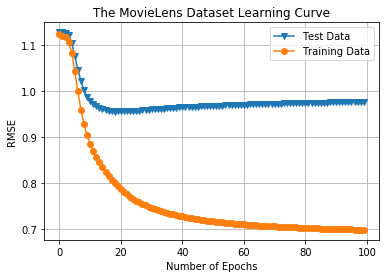

In [41]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

In [0]:
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 18, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

In [0]:
pmf.predict_all(rating_df, num_users, num_items)

## Q5

### (a)

In [44]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

patk_score = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
ratk_score = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)
rmse_score = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2117.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2122.55it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2138.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2145.09it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2117.75it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2159.31it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2137.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2139.54it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2125.53it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2123.22it/s]


Processing algorithm user-cosine


20000it [00:09, 2122.32it/s]
20000it [00:09, 2106.39it/s]
20000it [00:09, 2111.08it/s]
20000it [00:09, 2122.19it/s]
20000it [00:09, 2136.32it/s]


Processing algorithm item-cosine


20000it [00:09, 2125.34it/s]
20000it [00:09, 2116.99it/s]
20000it [00:09, 2128.60it/s]
20000it [00:09, 2118.75it/s]
20000it [00:09, 2112.43it/s]


Processing algorithm PMF


20000it [00:16, 1181.27it/s]
20000it [00:16, 1211.67it/s]
20000it [00:16, 1180.00it/s]
20000it [00:16, 1180.72it/s]
20000it [00:16, 1176.73it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2142.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2129.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2129.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2139.02it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2122.55it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2138.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2134.45it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2121.81it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2139.64it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2131.84it/s]


Processing algorithm user-cosine


20000it [00:09, 2131.50it/s]
20000it [00:09, 2123.13it/s]
20000it [00:09, 2092.15it/s]
20000it [00:09, 2115.35it/s]
20000it [00:09, 2108.84it/s]


Processing algorithm item-cosine


20000it [00:09, 2109.41it/s]
20000it [00:09, 2100.43it/s]
20000it [00:09, 2109.98it/s]
20000it [00:09, 2138.74it/s]
20000it [00:09, 2122.50it/s]


Processing algorithm PMF


20000it [00:16, 1184.59it/s]
20000it [00:16, 1180.82it/s]
20000it [00:17, 1171.87it/s]
20000it [00:16, 1179.80it/s]
20000it [00:16, 1176.84it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2113.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2127.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2120.11it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2106.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2144.79it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2114.74it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2128.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2142.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2133.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2121.98it/s]


Processing algorithm user-cosine


20000it [00:09, 2111.26it/s]
20000it [00:09, 2119.09it/s]
20000it [00:09, 2099.71it/s]
20000it [00:09, 2104.71it/s]
20000it [00:09, 2105.16it/s]


Processing algorithm item-cosine


20000it [00:09, 2124.75it/s]
20000it [00:09, 2098.82it/s]
20000it [00:09, 2105.85it/s]
20000it [00:09, 2102.13it/s]
20000it [00:09, 2103.11it/s]


Processing algorithm PMF


20000it [00:16, 1178.77it/s]
20000it [00:17, 1168.87it/s]
20000it [00:16, 1196.14it/s]
20000it [00:16, 1180.57it/s]
20000it [00:17, 1171.85it/s]


In [0]:
col_name = ['RMSE Mean','RMSE_CI_LL','RMSE_CI_UL','P@K Mean','P@K_CI_LL','P@K_CI_UL','R@K Mean', 'R@K_CI_LL','R@K_CI_UL']
rmse_score_df = pd.DataFrame(rmse_score)[1:].T
patk_score_df = pd.DataFrame(patk_score)[1:].T
ratk_score_df = pd.DataFrame(ratk_score)[1:].T

data_df = pd.concat([rmse_score_df,patk_score_df,ratk_score_df], axis =1)

data_df.columns = col_name


In [47]:
data_df

,RMSE Mean,RMSE_CI_LL,RMSE_CI_UL,P@K Mean,P@K_CI_LL,P@K_CI_UL,R@K Mean,R@K_CI_LL,R@K_CI_UL
popularity,3.15909,3.13929,3.17889,0.550583,0.405441,0.695725,0.484076,0.367137,0.601014
useraverage,1.04372,1.02893,1.0585,0.473637,0.341999,0.605275,0.441323,0.32931,0.553336
user-cosine,1.01735,1.00901,1.0257,0.555843,0.409598,0.702088,0.486269,0.369447,0.60309
item-cosine,1.02008,1.00682,1.03334,0.532216,0.383701,0.680732,0.474971,0.353573,0.596369
PMF,0.940388,0.925877,0.954899,0.557794,0.411561,0.704028,0.484181,0.368418,0.599943


### (b)

RMSE cannot be used on popularity, because RMSE does not apply on percentage values.

### (C)

The best algorithm for each metric are as follows:

* RMSE: PMF - The PMF method uses stochastic gradient descent on an objective function which targets to minimize the error. Therefore, PMF allows for the minimum RMSE.
* P@K: PMF - Because PMF looks to get the ratings as close to the actual, this generally results in a good generalization of the model, resulting in high precision.
* R@K: User-Cosine - The user-user focuses on recommending movies based on highest similarity. This is more informative and impactful towards recall metric as it is a ranking metric.


### (D)

Good RMSE in general is a good indicator that the model has good generalization and often result in better rankings just like what we saw for the P@K and R@K results above, but it does not necessarily indicate that RMSE scores are going to measure how well the model ranks the movie. For instance, let's say for movies with rating 5 were predicted all as 1 for one model and 2 for another model. This would result in a huge improvement in RMSE, but it's not performing any better in terms of differentiating between ones the users liked vs not liked. In this type of problem, RMSE can be misleading.

## Evaluation

### (a)

In [48]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
iisimilarity = SimBasedRecSys.cosine(train_matrix.T)

In [50]:
popularity_df = popularity_recsys.evaluate_test(rating_df,copy=True)

100000it [01:19, 1253.93it/s]


In [0]:
def top5(iisimilarity, moviesDF, movieID,k=5):
    # Pick top K based on predicted rating
    itemVector = iisimilarity[movieID-1,:]
    topK = nlargest(k+1, range(len(itemVector)), itemVector.take)
    topK = topK[1:]
    topMovie = list(map(lambda x: moviesDF[moviesDF.movieID == x+1]["movieTitle"].values[0], topK))
    return topMovie

In [0]:
#Get list of unpopular movies 
unpopular_movieID = popularity_df[popularity_df['popularity'] <0.5]['itemID'].values
unpopular_movieID = np.sort(unpopular_movieID)
unpopular_movieID = np.unique(unpopular_movieID)

In [0]:
unpopular_movieTitles = pd.DataFrame(columns = ['movieTitle'])

In [0]:
unpopular_movieTitles = pd.DataFrame(columns = ['movieTitle'])
for idx in unpopular_movieID:
    unpopular_movieTitles.loc[idx-1] = moviesDF['movieTitle'].iloc[idx-1]

In [0]:
unpopular_movieTitles['movieID'] = unpopular_movieID

In [56]:
unpopular_movieTitles

,movieTitle,movieID
1,GoldenEye (1995),2
2,Four Rooms (1995),3
4,Copycat (1995),5
12,Mighty Aphrodite (1995),13
15,French Twist (Gazon maudit) (1995),16
...,...,...
1677,Mat' i syn (1997),1678
1678,B. Monkey (1998),1679
1679,Sliding Doors (1998),1680
1680,You So Crazy (1994),1681


The chosen unpopular movies are: 
* Lost World: Jurassic Park (ID: 252)
* Aladdin and the King of Thieves (ID: 422)
* Die Hard 2 (ID:226)

In [57]:
moviesDF.loc[252-1]

movieID                                                           252
movieTitle                      Lost World: Jurassic Park, The (1997)
releaseDate                                               23-May-1997
videoReleaseDate                                                  NaN
IMDbURL             http://us.imdb.com/M/title-exact?Lost%20World%...
unknown                                                             0
action                                                              1
adventure                                                           1
animation                                                           0
childrens                                                           0
comedy                                                              0
crime                                                               0
documentary                                                         0
drama                                                               0
fantasy             

In [58]:
#item-item similarity for Lost World: Jurrasic Park
top5(iisimilarity, moviesDF,252)

['Independence Day (ID4) (1996)',
 'Twister (1996)',
 'Mission: Impossible (1996)',
 'Men in Black (1997)',
 'Fifth Element, The (1997)']

In [59]:
moviesDF.loc[422-1]

movieID                                                           422
movieTitle                     Aladdin and the King of Thieves (1996)
releaseDate                                               01-Jan-1996
videoReleaseDate                                                  NaN
IMDbURL             http://us.imdb.com/M/title-exact?Aladdin%20and...
unknown                                                             0
action                                                              0
adventure                                                           0
animation                                                           1
childrens                                                           1
comedy                                                              1
crime                                                               0
documentary                                                         0
drama                                                               0
fantasy             

In [60]:
#item-item similarity for Aladdin and the king of Thieves
top5(iisimilarity, moviesDF,422)

['Aristocats, The (1970)',
 'Mighty Morphin Power Rangers: The Movie (1995)',
 'Homeward Bound: The Incredible Journey (1993)',
 'Aladdin (1992)',
 'Beauty and the Beast (1991)']

In [61]:
moviesDF.loc[226-1]

movieID                                                           226
movieTitle                                          Die Hard 2 (1990)
releaseDate                                               01-Jan-1990
videoReleaseDate                                                  NaN
IMDbURL             http://us.imdb.com/M/title-exact?Die%20Hard%20...
unknown                                                             0
action                                                              1
adventure                                                           0
animation                                                           0
childrens                                                           0
comedy                                                              0
crime                                                               0
documentary                                                         0
drama                                                               0
fantasy             

In [62]:
#item-item similarity for Die Hard 2
top5(iisimilarity, moviesDF,226)

['Die Hard: With a Vengeance (1995)',
 'Under Siege (1992)',
 'True Lies (1994)',
 'Clear and Present Danger (1994)',
 'Batman (1989)']

### (b)

Yes, all movies that were chosen had a direct relationship with the extracted similar movies.

* Jurassic Park movie is an action, adventure, sciFi and thriller movie. The similar movies either have all four genre or have at least three.  For example, the independnce day is an alien movie that involves action, adventure, sciFi and thriller.

* The Aladdin and the king of Thieves movie is an animation, children and comedy movie. The similar movies are all children movies that are either comedy, animation or both. It is worth mentioning that the other series of the movie, Aladdin was also extracted for top 5 similar movies.

* Die Hard 2 is an action and thriller movie. The top 5 similar movies both involve action and thriller. In addition, the most similar movie for Die Hard 2 is Die Hard: With a vengeance which is another movie in the Die Hard Series.

## Different User Types

### (a)

In [0]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)

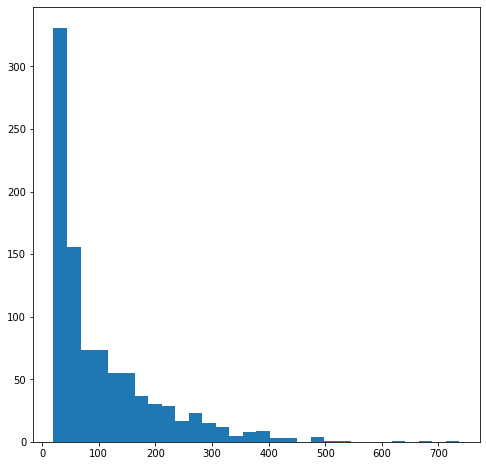

In [64]:
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
num_rating_user = np.sum(temp_matrix, axis =1)
plt.figure(figsize=(8, 8))
plt.hist(num_rating_user, bins = 30)
plt.show()

In [65]:
num_rating_pd = pd.Series(num_rating_user)
pd.cut(num_rating_pd, 30).value_counts().sort_index()

(19.283, 43.9]    331
(43.9, 67.8]      156
(67.8, 91.7]       73
(91.7, 115.6]      73
(115.6, 139.5]     55
(139.5, 163.4]     55
(163.4, 187.3]     37
(187.3, 211.2]     30
(211.2, 235.1]     29
(235.1, 259.0]     18
(259.0, 282.9]     22
(282.9, 306.8]     15
(306.8, 330.7]     12
(330.7, 354.6]      5
(354.6, 378.5]      8
(378.5, 402.4]      9
(402.4, 426.3]      3
(426.3, 450.2]      3
(450.2, 474.1]      0
(474.1, 498.0]      4
(498.0, 521.9]      1
(521.9, 545.8]      1
(545.8, 569.7]      0
(569.7, 593.6]      0
(593.6, 617.5]      0
(617.5, 641.4]      1
(641.4, 665.3]      0
(665.3, 689.2]      1
(689.2, 713.1]      0
(713.1, 737.0]      1
dtype: int64

The threshhold will be chosen at 65, because it seems like 65 number of ratings is the 50th percentile of the sample population.

In [0]:
train_matrix_above = train_matrix[(num_rating_user>=65)]
train_matrix_below = train_matrix[(num_rating_user < 65)]

In [0]:
def sim_matrix(matrix):
    similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
    return similarity_matrix

def predict_threshhold(train_matrix, base):
    if base =='user':
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = sim_matrix(train_matrix)
        normalizer = np.matmul(uu_similarity, temp_matrix)
        normalizer[normalizer == 0] = 1e-5
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
            
        columns = np.sum(predictionMatrix, axis=0)
            
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
        return predictionMatrix
    
    elif base == 'item':
        ########### your code goes here ###########
        train_matrix = train_matrix.T
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = sim_matrix(train_matrix)
        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer == 0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+ 1e-5)
        
        columns = np.sum(predictionMatrix, axis=0)
            
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
    
        return predictionMatrix.T

In [0]:
ii_prediction_above = predict_threshhold(train_matrix_above, 'item')
uu_prediction_above = predict_threshhold(train_matrix_above,'user')
ii_prediction_below = predict_threshhold(train_matrix_below, 'item')
uu_prediction_below = predict_threshhold(train_matrix_below,'user')

In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [70]:
print(rmse(ii_prediction_above,train_matrix_above))
print(rmse(uu_prediction_above,train_matrix_above))

print(rmse(ii_prediction_below,train_matrix_below))
print(rmse(uu_prediction_below,train_matrix_below))

0.9901070027415911
0.9500700033097215
0.8736613776906291
0.8706231699171362


Below threshold tends to perform better for both ii and uu in terms of RMSE compared to above the threshhold. This is because the users that have rated larger number of times may not have a specific type of movies they like and have more generic preferences which make the model harder to predict. On the other hand, for users that have smaller number of ratings may have strong preferences towards what they watch, which make the model easier to extract the similar users and items.